In [1]:
import sys
sys.path.append('..')
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.getcwd()
from gax import sersic
from gax.sersic import sersic_2d_linear_pix
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
import astropy
import numpy as np
from astropy.table import Table, vstack
import gax_fits as gfits
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator

bands = np.array(['U','G','R','I','Z'])
wavs = np.array([354.3e-9, 477.0e-9, 623.1e-9, 762.5e-9, 913.4e-9], dtype=float)



In [2]:
# Original                                                                                      Fiducial Wavelength
M51_B_O       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_B_kab2003.fits')         #4400 Å
M51_V_O       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_V_kab2003.fits')         #5500 Å
M51_H_alpha_O = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_Ha_sub_kab2003.fits')    #6750 Å
M51_R_O       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/NGC_5194_I_R_kab2003.fits')         #7000 Å


In [3]:
# Star Subtracted                                                                              Fiducial Wavelength
M51_B       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_B_KPNO.fits')         #4400 Å
M51_V       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_V_KPNO.fits')         #5500 Å
M51_H_alpha = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_Ha_KPNO.fits')        #6750 Å
M51_R       = gfits.Read('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_R_KPNO.fits')         #7000 Å


In [4]:
# Source parameters

M51_B_Table       = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_B_KPNO/0200/source_params.fits')         #4400 Å
#M51_V_Table       = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_V_KPNO.fits')         #5500 Å
#M51_H_alpha_Table = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_Ha_KPNO.fits')        #6750 Å
M51_R_Table       = gfits.Read_Table('/home/borge/Data/Case_studies/KPNO2.1/FICL_Processed/M_51_R_KPNO/0200/source_params.fits') 

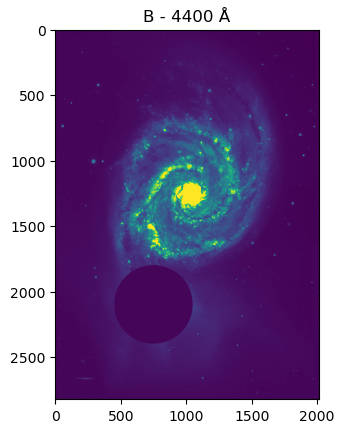

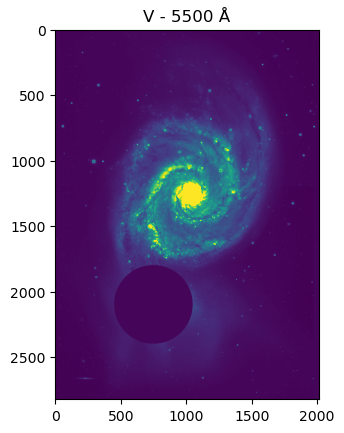

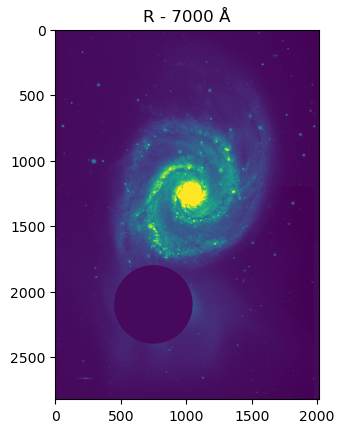

In [5]:
# Make a quick image show function

def show(image,range=(0.5,99.5)):
    minI,maxI = np.percentile(image,range)
    plt.imshow(image,vmin=minI,vmax=maxI)

plt.figure()
plt.title('B - 4400 Å')
show(M51_B)

plt.figure()
plt.title('V - 5500 Å')
show(M51_V)

plt.figure()
plt.title('R - 7000 Å')
show(M51_R)

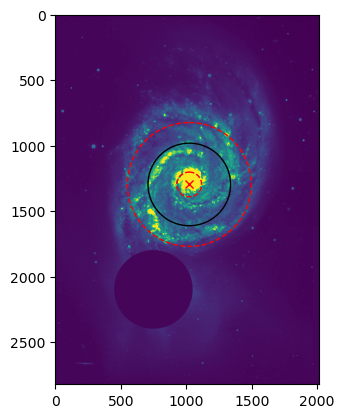

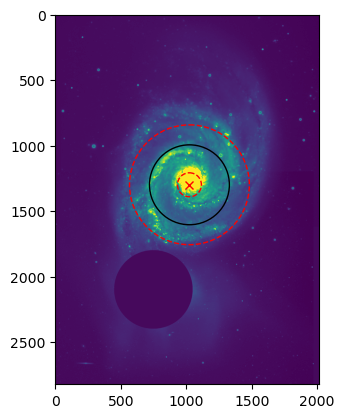

In [6]:
# Check Table params with Overlay

gfits.Overlay_table_info(M51_B,M51_B_Table,0.3,1.5)

gfits.Overlay_table_info(M51_R,M51_R_Table,0.3,1.5)

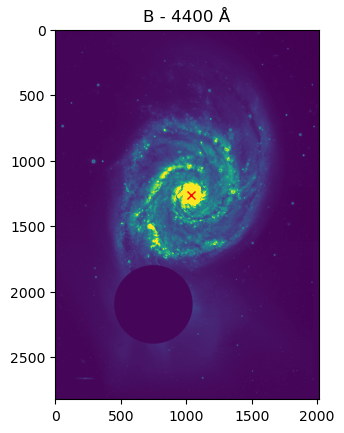

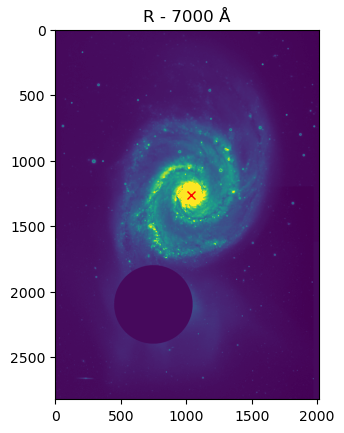

In [7]:
# Check Intensity max pos
def max_I_pos(image):
    bulge_intensity = np.nanmax(image)
    bulge_pos = np.asarray(np.argwhere(image == bulge_intensity))
    return bulge_pos.ravel()[::-1]

x_B,y_B = max_I_pos(M51_B)

x_R,y_R = max_I_pos(M51_R)


plt.figure()
show(M51_B)
plt.title('B - 4400 Å')
plt.plot(x_B,y_B,'rx')

plt.figure()
show(M51_R)
plt.title('R - 7000 Å')
plt.plot(x_R,y_R,'rx')

In [8]:
# Ammend table with bulge pos
height,width = M51_B.shape

# Image centre relative coords
x_B_rel = x_B - width/2
y_B_rel = y_B - height/2

x_R_rel = x_R - width/2
y_R_rel = y_R - height/2

# Set the table coords
M51_B_Table['x'] = x_B_rel
M51_B_Table['y'] = y_B_rel

M51_R_Table['x'] = x_R_rel
M51_R_Table['y'] = y_R_rel

Text(0.5, 1.0, 'R')

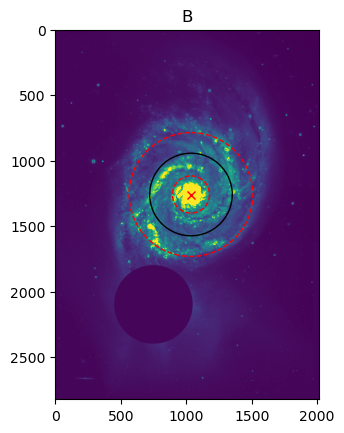

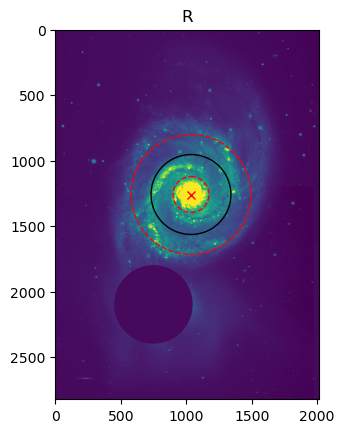

In [9]:
# Check changes effective

N_Re = 0.45

gfits.Overlay_table_info(M51_B,M51_B_Table,N_Re,1.5)
plt.title('B')
gfits.Overlay_table_info(M51_R,M51_R_Table,N_Re,1.5)
plt.title('R')

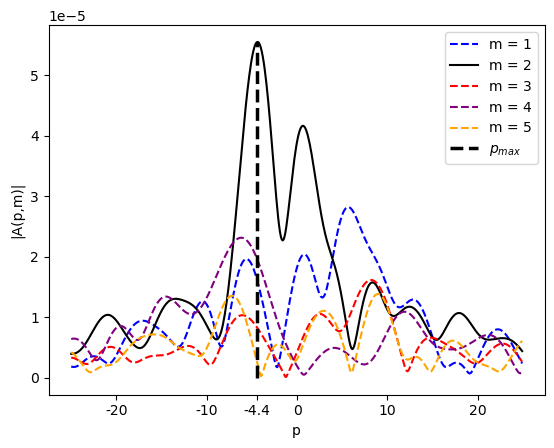

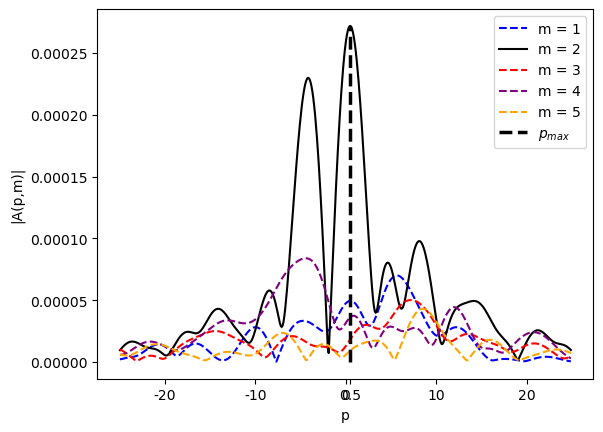

In [10]:
# Run number of arms on B and R

m_B = gfits.Number_of_arms(M51_B,M51_B_Table,N_Re,True,False,objid='M51 B',byte_order=True)

m_R = gfits.Number_of_arms(M51_R,M51_R_Table,N_Re,True,False,objid='M51 R',byte_order=True)

In [11]:
# Fix the byte order of the images

M51_B = M51_B.byteswap().newbyteorder('L')

M51_R = M51_R.byteswap().newbyteorder('L')

In [12]:
# Run SFT on B and R

phi_B, theta_B = gfits.Spiral_Fourier_Transform(M51_B,M51_B_Table,N_Re,m_B,False,False)

phi_R, theta_R = gfits.Spiral_Fourier_Transform(M51_R,M51_R_Table,N_Re,m_R,False,False)

(1, 1) [1036]
(1, 1) [1036]
Winding angle φ = 24.44395478041797  Pattern position angle θ =  4.863817251402531
(1, 1) [1036]
(1, 1) [1036]
Winding angle φ = -75.96375653206375  Pattern position angle θ =  -5.526448643250862


In [13]:
rad_arr, phi_arr, power_arr = gfits.pitch_angle_against_radius(M51_B,M51_B_Table,N=2)

In [14]:
phi_arr.shape

(70, 6)

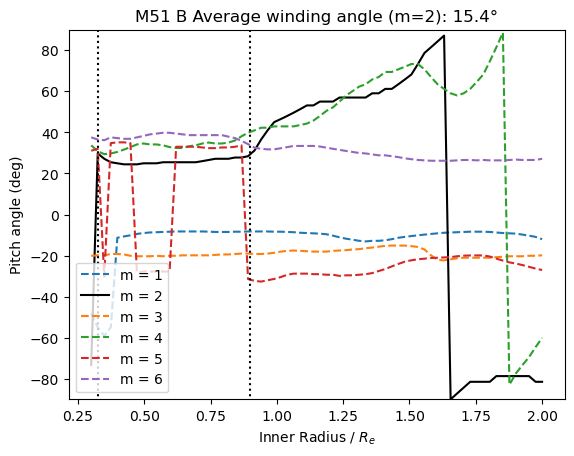

In [15]:
gfits.plot_radial_pitch_angle_dependance('M51 B',phi_arr,rad_arr)
inner_stable = 0.325
outer_stable = 0.9

plt.axvline(inner_stable,-80,80,c='k',linestyle=':')
plt.axvline(outer_stable,-80,80,c='k',linestyle=':')

In [16]:
# Error on the angle over the stable region:

# Stable between ~ 0.3-2.1 R_e

def Stable_region_fit_error(Inner_radii_multiples,phi_array_test,Relative_A_p_max_array,Test_Image,Test_Table,Stable_inner,Stable_outer):

    # Select dominant harmonic mode with highest average power
    m = np.argmax(np.average(Relative_A_p_max_array,axis=0))

    # Get Pitch angle data:

    Stable_radii_m = Inner_radii_multiples[int(np.argwhere(Inner_radii_multiples >= Stable_inner)[0]):int(np.argwhere(Inner_radii_multiples >= Stable_outer)[0])]
    Stable_pitch   = phi_array_test[int(np.argwhere(Inner_radii_multiples >= Stable_inner)[0]):
        int(np.argwhere(Inner_radii_multiples >= Stable_outer)[0])][:,m]

    #print(Stable_radii_m.shape,Stable_pitch.shape) # Check everything is the same size still

    # Get std dev of stable region
    sigma_ = np.std(Stable_pitch)

    # Work out where 90% R_max is

    height,width = Test_Image.shape
    x0 = np.array([Test_Image.shape[1]/2 + np.asarray(Test_Table['x'])]).astype(int)
    y0 = np.array([Test_Image.shape[0]/2 + np.asarray(Test_Table['y'])]).astype(int)
    R_e_pix = 10**(Test_Table['log_re'])
    max_radius = min(x0, y0, width-x0, height-y0)
    max_lim_R_e = (max_radius*0.9)/R_e_pix

    # Therefore Beta:
    beta_  = Stable_inner - max_lim_R_e

    # lambda:
    lambda_ = Stable_outer - Stable_inner

    disk_fraction = lambda_/max_lim_R_e

    # epsilon:
    p_step = 0.1
    epsilon = np.arctan2(-p_step,m)

    # Calculate pitch angle error

    avg_phi = np.average(Stable_pitch)
    E_phi = np.sqrt((beta_*sigma_/lambda_)**2 + epsilon**2)

    print('Spiral pitch angle: ',np.around(avg_phi,2),'±',np.around(E_phi[0],2),' degrees over ',np.around(disk_fraction[0],3),' of the galactic disk')
    return E_phi,beta_,sigma_,lambda_,epsilon,disk_fraction

In [17]:
E_phi,beta_,sigma_,lambda_,epsilon,disk_fraction = Stable_region_fit_error(rad_arr, phi_arr, power_arr, M51_B, M51_B_Table, inner_stable, outer_stable)

Spiral pitch angle:  25.93 ± [4.99]  degrees over  [0.206]  of the galactic disk


In [35]:
E_phi,beta_,sigma_,lambda_,epsilon,disk_fraction

(array([[4.98979912]]),
 array([[-2.46483671]]),
 1.1637939575466723,
 0.575,
 -0.09966865249116204,
 array([[0.20610525]]))

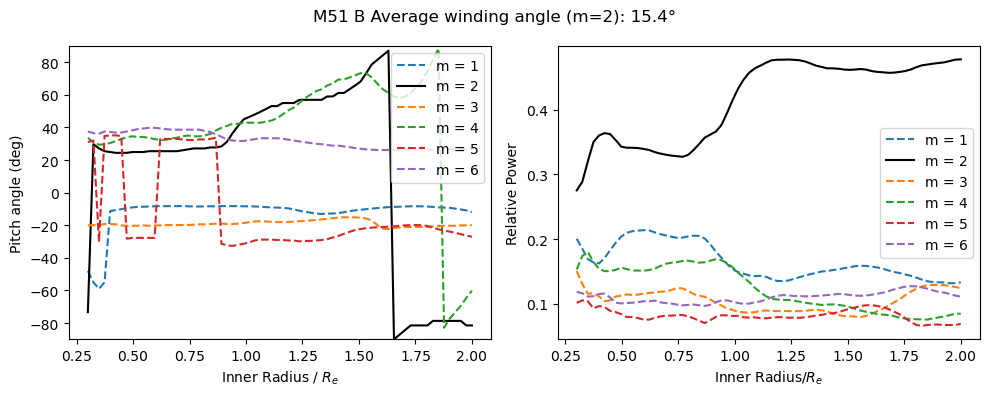

In [18]:
gfits.plot_pitch_angle_relative_power('M51 B',phi_arr,rad_arr,power_arr)

In [19]:
# Now plot the overlay on the image
Test_Image = M51_B
Test_Table = M51_B_Table

# Generate a set of spiral points using the information
# Going to try with a Boolean array instead
# Get image info:
height, width = Test_Image.shape[:2]   

R_e = 10**Test_Table['log_re']
x_centre = int(Test_Table['x'] + width/2)
y_centre = int(Test_Table['y'] + height/2)

# Create Polar Spiral
#A_p_max = A_p_m[np.argmax(A_p_m)]
argument = np.radians(-20)#np.angle(A_p_max)#np.radians(35)
#print(argument)
argument_2 = np.radians(np.degrees(argument)+180)
r_0 = 1                                     # Scale 1:1 pix
theta = np.linspace(2*np.pi,8*(np.pi),3600)
phi = -16.8#-14.560275619356032 #np.degrees(np.arctan((0-m)/p_max))


#===================================================================
# Add uncertainty curves 
phi_ERR = 4.8

r_low = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi-phi_ERR)))) 
r_high = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi+phi_ERR)))) 

x = r_low*np.cos(theta)
y = r_low*np.sin(theta) 
vector_low = np.stack([x,y],axis=1).T

x = r_high*np.cos(theta)
y = r_high*np.sin(theta) 
vector_high = np.stack([x,y],axis=1).T

rot_mat = np.array([[np.cos(argument),-np.sin(argument)],
                [np.sin(argument), np.cos(argument)]])

rot_mat_2 = np.array([[np.cos(argument_2),-np.sin(argument_2)],
                [np.sin(argument_2), np.cos(argument_2)]])

rotated_vector_low = rot_mat @ vector_low
rotated_vector_2_low = rot_mat_2 @ vector_low

x_low = rotated_vector_low[0] #+ x_centre
y_low = rotated_vector_low[1] #+ y_centre

x_2low = rotated_vector_2_low[0] #+ x_centre
y_2low = rotated_vector_2_low[1] #+ y_centre

rotated_vector_high = rot_mat @ vector_high
rotated_vector_2_high = rot_mat_2 @ vector_high

x_high = rotated_vector_high[0] #+ x_centre
y_high = rotated_vector_high[1] #+ y_centre

x_2high = rotated_vector_2_high[0] #+ x_centre
y_2high = rotated_vector_2_high[1] #+ y_centre


#===================================================================

r = r_0 *np.exp(theta*np.abs(np.tan(np.radians(phi)))) 

# Convert to Cartesian
x = r*np.cos(theta)
y = r*np.sin(theta) 
vector = np.stack([x,y],axis=1).T

rot_mat = np.array([[np.cos(argument),-np.sin(argument)],
                [np.sin(argument), np.cos(argument)]])

rot_mat_2 = np.array([[np.cos(argument_2),-np.sin(argument_2)],
                [np.sin(argument_2), np.cos(argument_2)]])

rotated_vector = rot_mat @ vector
rotated_vector_2 = rot_mat_2 @ vector

x_ = rotated_vector[0] #+ x_centre
y_ = rotated_vector[1] #+ y_centre

x_2 = rotated_vector_2[0] #+ x_centre
y_2 = rotated_vector_2[1] #+ y_centre

range_min = inner_stable * R_e
range_max = outer_stable * R_e

# Create a boolean mask to filter out points outside the range
mask = (np.sqrt(x_**2 + y_**2) >= range_min) & (np.sqrt(x_**2 + y_**2) <= range_max)
masklow = (np.sqrt(x_low**2 + y_low**2) >= range_min) & (np.sqrt(x_low**2 + y_low**2) <= range_max)
maskhigh = (np.sqrt(x_high**2 + y_high**2) >= range_min) & (np.sqrt(x_high**2 + y_high**2) <= range_max)

# Apply the mask to the data
x_trimmed = x_[mask] + x_centre
y_trimmed = -1*(y_[mask]) + y_centre

x_2_trimmed = x_2[mask] + x_centre
y_2_trimmed = -1*(y_2[mask]) + y_centre

# Low
#=====

x_trimmedlow = x_low[masklow] + x_centre
y_trimmedlow = -1*(y_low[masklow]) + y_centre

x_2_trimmedlow = x_2low[masklow] + x_centre
y_2_trimmedlow = -1*(y_2low[masklow]) + y_centre

# High
#======

x_trimmedhigh = x_high[maskhigh] + x_centre
y_trimmedhigh = -1*(y_high[maskhigh]) + y_centre

x_2_trimmedhigh = x_2high[maskhigh] + x_centre
y_2_trimmedhigh = -1*(y_2high[maskhigh]) + y_centre

(-0.5, 2012.5, 2821.5, -0.5)

<Figure size 640x480 with 0 Axes>

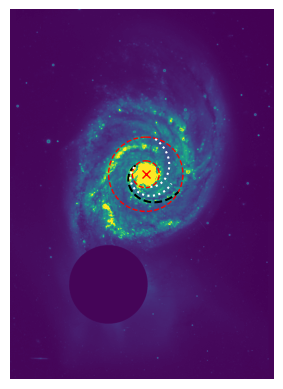

<Figure size 640x480 with 0 Axes>

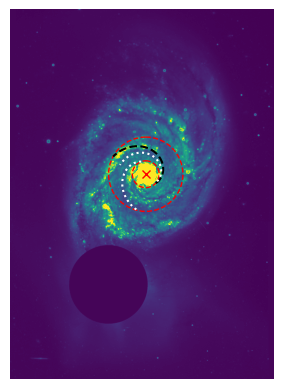

In [20]:
plt.figure()
gfits.Overlay_table_info(Test_Image,Test_Table,inner_stable,outer_stable,R_e_on=False)
# Arm 1
plt.plot(x_trimmed,y_trimmed,'black',linestyle='--')
# Uncertainty
plt.plot(x_trimmedlow,y_trimmedlow,'white',linestyle=':')
plt.plot(x_trimmedhigh,y_trimmedhigh,'white',linestyle=':')
plt.axis('off')

plt.figure()
gfits.Overlay_table_info(Test_Image,Test_Table,inner_stable,outer_stable,R_e_on=False)
# Arm 2
plt.plot(x_2_trimmed,y_2_trimmed,'black',linestyle='--')
# Uncertainty
plt.plot(x_2_trimmedlow,y_2_trimmedlow,'white',linestyle=':')
plt.plot(x_2_trimmedhigh,y_2_trimmedhigh,'white',linestyle=':')
plt.axis('off')

<Figure size 640x480 with 0 Axes>

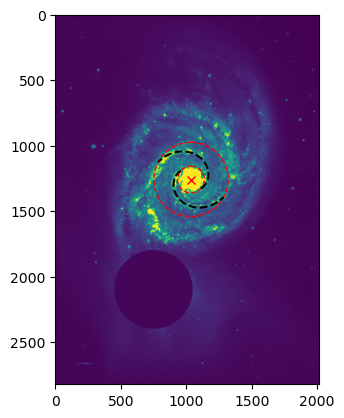

In [27]:
plt.figure()
gfits.Overlay_table_info(Test_Image,Test_Table,inner_stable,outer_stable,R_e_on=False)
plt.plot(x_trimmed,y_trimmed,'black',linestyle='--')
plt.plot(x_2_trimmed,y_2_trimmed,'black',linestyle='--')

In [26]:
# Get R_e in pixels
R_e
ang_Re = 

315.17973670249535


In [21]:
# Create Spiral points arrays:

spiral_1_points = np.vstack([x_trimmed,y_trimmed]).T
spiral_2_points = np.vstack([x_2_trimmed,y_2_trimmed]).T

spiral_1_points.shape, spiral_2_points.shape

((644, 2), (644, 2))

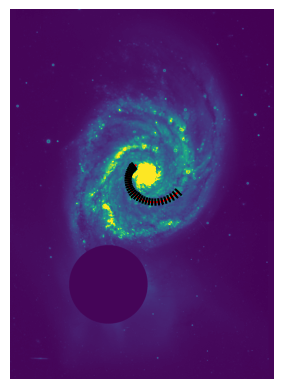

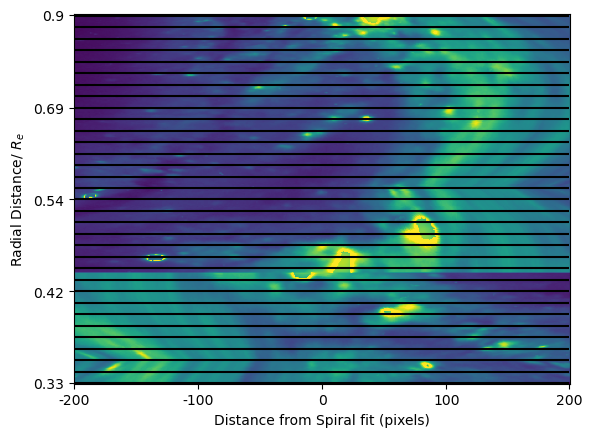

In [25]:
normals_B_1 = gfits.Spiral_normal_distributions(M51_B,M51_B_Table,spiral_1_points,int(len(spiral_1_points)/2),200,True,True)
normals_B_2 = gfits.Spiral_normal_distributions(M51_B,M51_B_Table,spiral_2_points,int(len(spiral_2_points)/2),200,False,False)

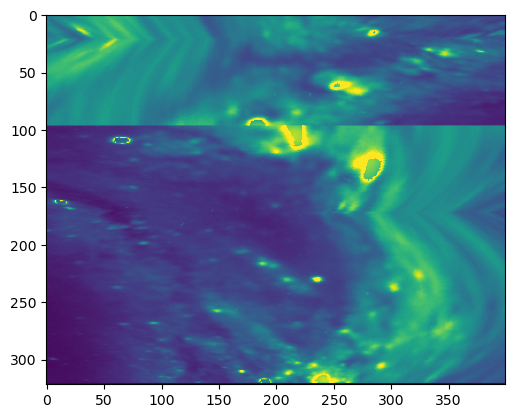

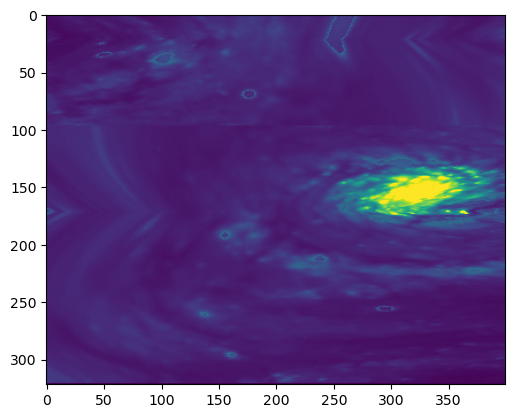

In [23]:
plt.figure()
show(normals_B_1)

plt.figure()
show(normals_B_2)

In [29]:
from astropy.wcs import WCS
hdul = fits.open('/home/borge/Data/Case_studies/KPNO2.1/Cleaned/M_51_B_KPNO.fits')

image = M51_B

fits_info = {}  # Create dictionary for header info
for key, value in hdul[0].header.items():
    fits_info[key] = value

# Retreive Pixel scale conversion factors
X_deg = fits_info['CD1_1'] 
Y_deg = fits_info['CD2_2'] 

# Reference coord and corresponding pixel
RA_ref_coord  = fits_info['CRVAL1'] 
DEC_ref_coord = fits_info['CRVAL2'] 

RA_ref_pix  = fits_info['CRPIX1'] 
DEC_ref_pix = fits_info['CRPIX2'] 

# Calculate Image pixel coords through WCS
wcs = WCS(hdul[0].header)

# Create arrays to store the RA and Dec coordinates
RA = np.empty(image.shape)
DEC = np.empty(image.shape)

# Loop over all pixel coordinates and convert to RA and Dec
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        ra, dec = wcs.all_pix2world(j, i, 0)
        RA[i,j] = ra
        DEC[i,j] = dec



In [31]:
RA_sample_mask = np.linspace(0,(RA[0,:].shape[0]-1),5).astype(int)
DEC_sample_mask = np.linspace(0,(DEC[:,0].shape[0]-1),5).astype(int)
RA_arr  = RA[0,:]
DEC_arr = DEC[:,0]

RA_ticks  = RA_arr[RA_sample_mask]
DEC_ticks = DEC_arr[DEC_sample_mask]


Text(0, 0.5, 'DEC (Deg)')

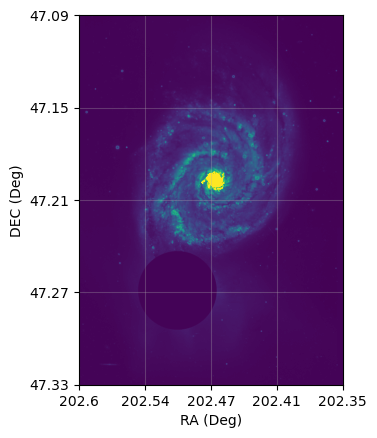

In [33]:
plt.figure()
vmin, vmax = np.percentile(image, (0.2, 99.8))
plt.imshow(image,cmap='viridis',vmin=vmin,vmax=vmax)
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))
plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')

Text(0, 0.5, 'DEC (Deg)')

<Figure size 640x480 with 0 Axes>

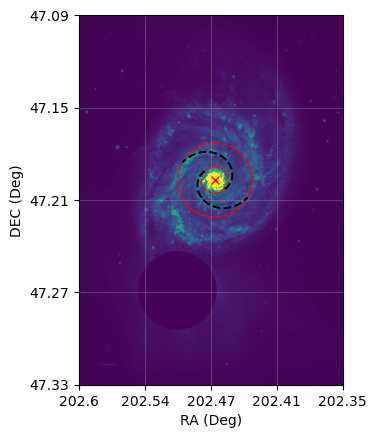

In [34]:
plt.figure()
gfits.Overlay_table_info(Test_Image,Test_Table,inner_stable,outer_stable,R_e_on=False)
plt.plot(x_trimmed,y_trimmed,'black',linestyle='--')
plt.plot(x_2_trimmed,y_2_trimmed,'black',linestyle='--')
plt.imshow(image,cmap='viridis',vmin=vmin,vmax=vmax)
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))
plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')

Text(0, 0.5, 'DEC (Deg)')

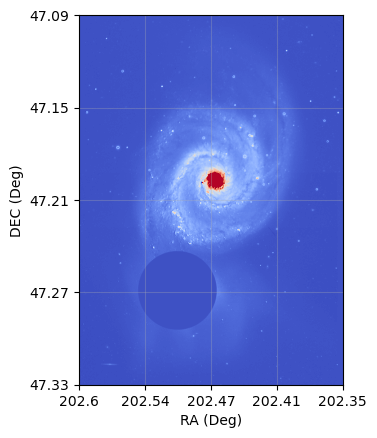

In [38]:
# Make a colour map of the galaxy
M51_B_V_Colour = -2.5*np.log10(M51_B/M51_V)
plt.figure()
minI, maxI = np.percentile(M51_B_V_Colour, (0.2, 99.8))
plt.imshow(M51_B_V_Colour,cmap='coolwarm',vmin=minI,vmax=maxI)
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))
plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')

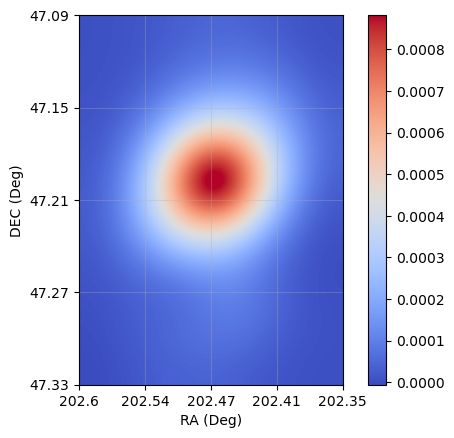

In [68]:
from scipy import ndimage
sigma = 250.0  #50.0  # Standard deviation of the Gaussian kernel
smoothed_M51_B_V_Colour = ndimage.gaussian_filter(M51_B_V_Colour, sigma=sigma)
plt.figure()
minI, maxI = np.percentile(smoothed_M51_B_V_Colour, (0.2, 99.8))
plt.imshow(smoothed_M51_B_V_Colour,cmap='coolwarm',vmin=minI,vmax=maxI)
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))
plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')
plt.colorbar()

#plt.plot(x0,y0,'cx')


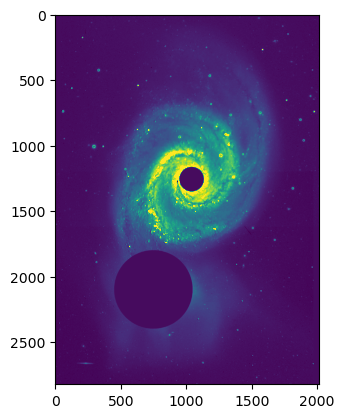

In [ ]:
im = gfits.R_e_bulge_mask(M51_B_V_Colour,M51_B_Table)
show(im)

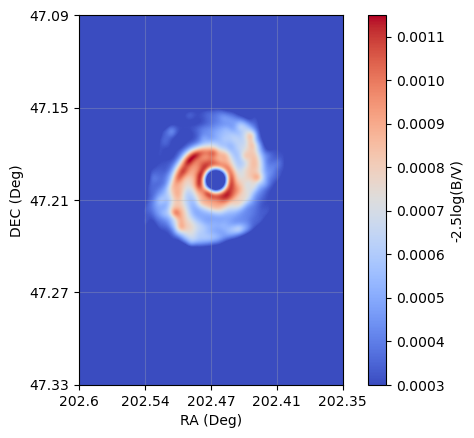

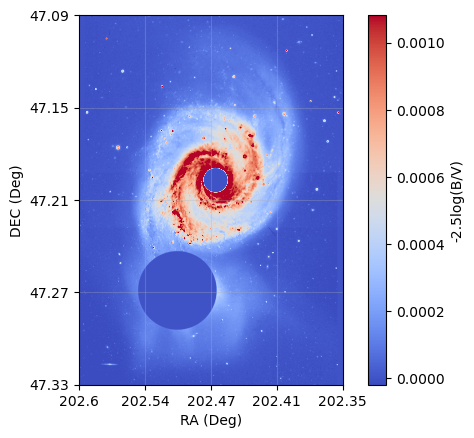

In [ ]:
sigma = 25.0  # Standard deviation of the Gaussian kernel
smoothed_im = ndimage.gaussian_filter(im, sigma=sigma)
plt.figure()
#minI, maxI = np.percentile(smoothed_im, (0.2, 99.8))
plt.imshow(smoothed_im,cmap='coolwarm',vmin=0.0003,vmax=np.max(smoothed_im))#vmin=minI,vmax=maxI)
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))
plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')
plt.colorbar(label='-2.5log(B/V)')

plt.figure()
minI, maxI = np.percentile(smoothed_im, (0.2, 99.8))
plt.imshow(im,cmap='coolwarm',vmin=minI,vmax=maxI) # ,vmin=0.0003,vmax=np.max(smoothed_im))
plt.grid(True,alpha=0.3)
plt.xticks(RA_sample_mask,np.around(RA_ticks,2))
plt.xlabel('RA (Deg)')
plt.yticks(DEC_sample_mask,np.around(DEC_ticks,2))
plt.ylabel('DEC (Deg)')
plt.colorbar(label='-2.5log(B/V)')